## Предсказание пола/возраста по посещениям сайтов

Для начала, подключим хранилище s3, содержащее исходные данные:

In [25]:
!chmod 600 s3_passwd
!mkdir -p mnt
!s3fs hsevkhack mnt -o url=http://hb.vkcs.cloud -o use_path_request_style -o passwd_file=s3_passwd -o ro

s3fs: MOUNTPOINT directory mnt is not empty. if you are sure this is safe, can use the 'nonempty' mount option.


Убедимся, что в директории `mnt` содержатся соответствующие таблицы:

In [26]:
!ls mnt/

geo_dataframe.csv  requests  train_users.csv


Если по каким-то причинам директорию смонтировать не удалось, используйте код ниже, чтобы скачать данные к себе в локальное хранилище. В противном случае **пропустите следующую ячейку**.

In [7]:
import subprocess
!mkdir -p data
!wget https://hsehack.hb.ru-msk.vkcs.cloud/geo_dataframe.csv -P data
!wget https://hsehack.hb.ru-msk.vkcs.cloud/train_users.csv -P data
!mkdir -p data/requests
for i in range(30):
    print(f"Downloading part {i}...")
    subprocess.call(["wget", f"https://hsehack.hb.ru-msk.vkcs.cloud/requests/part_{i}.parquet", "-q", "-P", "data/requests"])

--2024-04-20 13:38:45--  https://hsehack.hb.ru-msk.vkcs.cloud/geo_dataframe.csv
Resolving hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)... 95.163.53.117
Connecting to hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63042 (62K) [text/csv]
Saving to: ‘data/geo_dataframe.csv’

geo_dataframe.csv   100%[===================>]  61.56K  --.-KB/s    in 0.003s  

2024-04-20 13:38:45 (22.5 MB/s) - ‘data/geo_dataframe.csv’ saved [63042/63042]

--2024-04-20 13:38:45--  https://hsehack.hb.ru-msk.vkcs.cloud/train_users.csv
Resolving hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)... 95.163.53.117
Connecting to hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66826127 (64M) [text/csv]
Saving to: ‘data/train_users.csv’

train_users.csv     100%[===================>]  63.73M  41.5MB

## Загружаем данные

Используем Pandas для работы с таблицами. `geo_dataframe` содержит данные о геолокации - регионе и стране.

In [1]:
import pandas as pd

geo = pd.read_csv('mnt/geo_dataframe.csv')
geo

,geo_id,region_id,country_id
0,1,157,40
1,2,161,40
2,3,265,54
3,4,122,54
4,5,78,40
...,...,...,...
5528,5529,246,54
5529,5530,-1,63
5530,5531,101,40
5531,5532,21,68


Таблица `train_users` - это ваша обучающая выборка, содержащая пол и возраст пользователей. Аналогичная таблица для тестового датасета будет вам предоставлена за час до stop coding.

In [2]:
users = pd.read_csv('mnt/train_users.csv')
users

,user_id,gender,age
0,2,1,61
1,3,1,55
2,6,0,46
3,14,0,66
4,17,0,53
...,...,...,...
4999995,17588859,1,64
4999996,17588860,0,69
4999997,17588861,1,51
4999998,17588864,0,30


Для примера - вот распределение пользователей по полу:

<AxesSubplot: xlabel='gender'>

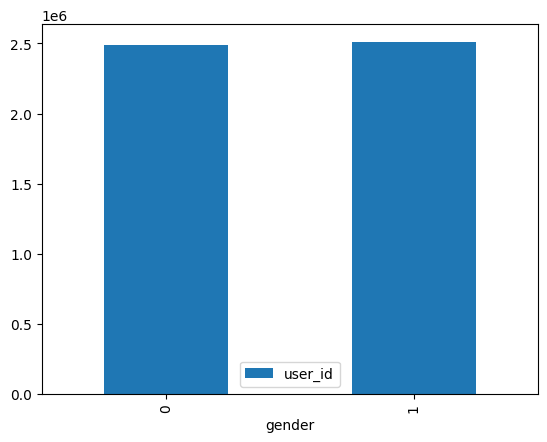

In [11]:
users.groupby('gender').agg({ 'user_id' : len }).plot.bar()

Основные данные о посещениях пользователями сайтов содержатся в табличке `requests`, представленной в формате parquet. Вы можете загрузить только одну часть таблички, или же всю таблицу, если она поместиться в памяти:

In [3]:
req1 = pd.read_parquet('mnt/requests/part_0.parquet')
req1

,timestamp,geo_id,referer,user_id,user_agent
0,1712169477,1224,https://www.domain_1118/path_107938,1628092,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...
1,1711945301,2540,https://domain_3207/path_175610,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...
2,1712154596,4402,https://domain_2194/path_172150,8274161,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
3,1711941903,3833,https://domain_2042/path_144480,17082498,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
4,1712088484,3866,https://domain_3191/path_9105,12787875,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
...,...,...,...,...,...
10000449,1712161101,702,https://domain_662/path_131980,2062442,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
10000450,1711940706,3515,https://domain_1784/path_45033,2375719,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...
10000451,1712107755,3173,https://domain_1654/path_48166,11781572,Mozilla/5.0 (Linux; arm_64; Android 13; SM-A14...
10000452,1712107427,3833,https://domain_1654/path_10504,15183751,Mozilla/5.0 (Linux; arm_64; Android 12; SM-M21...


In [87]:
import pandas as pd
import numpy as np
# удаляем строки с пропущенными значениями
df_cleaned = req1.dropna()
print(df_cleaned.size)
print(req1.size)

50002270
50002270


In [78]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 1.1 MB/s            
Note: you may need to restart the kernel to use updated packages.


## Дерзайте!

Вам необходимо построить предсказательную модель для прогнозирования пола и возраста пользователей по их посещениям. Таблица с тестовыми пользователями будет предоставлена вам за час до stop coding.

ВАЖНО:
* Таблицу с тестовыми данными нельзя использовать для обучения модели. Если жюри увидит, что вы использовали табличку с тестовыми данными - точность модели будет оцениваться в 0 баллов.
* В ходе выступления необходимо продемонстрировать точность модели на тестовых данных.

In [4]:
full_data = req1
full_data = full_data.merge(users, on='user_id')
full_data = full_data.merge(geo, on='geo_id')
full_data.head()

,timestamp,geo_id,referer,user_id,user_agent,gender,age,region_id,country_id
0,1711945301,2540,https://domain_3207/path_175610,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...,1,75,135,199
1,1711972560,2540,https://domain_207/path_159182,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...,1,75,135,199
2,1711954939,2540,https://domain_698/path_130576,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...,1,75,135,199
3,1711988377,2540,https://domain_551/path_118633,4005154,Mozilla/5.0 (Linux; Android 11; M2102J20SG) Ap...,0,51,135,199
4,1711954815,2540,https://domain_551/path_175610,16503401,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,0,71,135,199


In [45]:
from user_agents import parse

browser = {}
os = {}
device ={}
referer = {}
cnt_browser = 0
cnt_device = 0
cnt_os = 0
cnt_referer = 0

d = {}
d['browser_id'] = []
d['os_id'] = []
d['device_id'] = []
d['ref_id'] = []


for index, row in full_data.iterrows():
    user_agent = parse(row['user_agent'])
    str_browser = str(user_agent.browser)
    str_device = str(user_agent.device)
    str_os = str(user_agent.os)
    str_referer = row['referer']
    
    if str_browser in browser:
        d['browser_id'].append(browser[str_browser])
    else:
        browser[str_browser] = cnt_browser
        d['browser_id'].append(cnt_browser)
        cnt_browser += 1
        
        
    if str_os in os:
        d['os_id'].append(os[str_os])
        
    else:
        os[str_os] = cnt_os
        d['os_id'].append(cnt_os)
        cnt_os += 1
        
    if str_device in device:
        d['device_id'].append(device[str_device])
    else:
        device[str_device] = cnt_device
        d['device_id'].append(cnt_device)
        cnt_device += 1
    if str_referer  in referer:
        d['ref_id'].append(referer[row['referer']])
    else:
        referer[str_referer] = cnt_referer
        d['ref_id'].append(cnt_referer)
        cnt_referer += 1

df = pd.DataFrame.from_dict(d)


In [121]:
data[(data['referer'] == '')].size

254891

In [124]:
data = pd.concat([full_data, df], axis=1)
data

,timestamp,geo_id,referer,user_id,user_agent,gender,age,region_id,country_id,browser_id,os_id,device_id,ref_id
0,1711945301,2540,0,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...,1,75,135,199,0,0,0,0
1,1711972560,2540,1,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...,1,75,135,199,0,0,0,1
2,1711954939,2540,2,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...,1,75,135,199,0,0,0,2
3,1711988377,2540,3,4005154,Mozilla/5.0 (Linux; Android 11; M2102J20SG) Ap...,0,51,135,199,1,1,1,3
4,1711954815,2540,4,16503401,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,0,71,135,199,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4661102,1712123734,1045,https://domain_2238/path_175610,8953872,Mozilla/5.0 (Linux; arm_64; Android 13; 220111...,0,42,271,40,64,4,143,40
4661103,1711951088,1045,https://domain_2238/path_175610,8953872,Mozilla/5.0 (Linux; arm_64; Android 13; 220111...,0,42,271,40,64,4,143,40
4661104,1712028514,40,https://domain_2194/path_117211,7184373,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1,63,140,40,3,3,3,39
4661105,1712163962,2176,https://domain_2042/path_79235,6972857,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1,40,-1,27,4,3,3,2249


In [126]:
data = data[(data['age'] < 75) & (data['region_id'] != -1) & (data['referer'] != '')]
data.size

53643980

In [33]:
pip install pyyaml ua-parser user-agents

SyntaxError: invalid syntax (2332430140.py, line 1)

In [1]:
from user_agents import parse

In [18]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 98.2 MB 38.1 MB/s            
     |████████████████████████████████| 47 kB 4.5 MB/s             
Note: you may need to restart the kernel to use updated packages.


In [127]:

# Делаем датасет из параметров и целевой переменной
# Выкидываем из параметров, по которым будем обучать модель столбцы со строками и с целевыми переменными
X = data.loc[:, ~data.columns.isin(['gender', 'age', 'user_agent', 'referer'])]
# Оставляем только столбец с одной целевой переменной - полом
y = data.loc[:, data.columns.isin(['gender'])]
X

,timestamp,geo_id,user_id,region_id,country_id,browser_id,os_id,device_id,ref_id
3,1711988377,2540,4005154,135,199,1,1,1,3
4,1711954815,2540,16503401,135,199,2,2,2,4
5,1712148736,2540,457276,135,199,3,3,3,5
9,1712152946,2540,7571719,135,199,4,2,4,4
12,1712114591,2540,15972555,135,199,6,4,5,11
...,...,...,...,...,...,...,...,...,...
4661098,1712072394,5179,11131354,19,40,4,3,3,33294
4661101,1712125366,1045,8953872,271,40,64,4,143,40
4661102,1712123734,1045,8953872,271,40,64,4,143,40
4661103,1711951088,1045,8953872,271,40,64,4,143,40


In [135]:
# разбиваем датасет на обучающую и тестовые выборки

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [129]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()


In [136]:
cat.fit(X_train,y_train, verbose=100)

Learning rate set to 0.327646
0:	learn: 0.6885613	total: 113ms	remaining: 1m 52s
100:	learn: 0.6706992	total: 11.3s	remaining: 1m 40s
200:	learn: 0.6677768	total: 22.8s	remaining: 1m 30s
300:	learn: 0.6662581	total: 34.2s	remaining: 1m 19s
400:	learn: 0.6651572	total: 45.7s	remaining: 1m 8s
500:	learn: 0.6640454	total: 57s	remaining: 56.7s
600:	learn: 0.6631667	total: 1m 8s	remaining: 45.3s
700:	learn: 0.6622900	total: 1m 20s	remaining: 34.1s
800:	learn: 0.6615292	total: 1m 29s	remaining: 22.2s
900:	learn: 0.6608770	total: 1m 38s	remaining: 10.9s
999:	learn: 0.6601866	total: 1m 48s	remaining: 0us


In [137]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, cat.predict(X_test))

0.5932506312917125

In [101]:
from catboost import CatBoostRegressor
cat_reg = CatBoostRegressor()

In [132]:
# Делаем датасет из параметров и целевой переменной
# Выкидываем из параметров, по которым будем обучать модель столбцы со строками и с целевыми переменными
X1 = data.loc[:, ~data.columns.isin(['gender', 'age', 'user_agent', 'referer'])]
# Оставляем только столбец с одной целевой переменной - полом
y1 = data.loc[:, data.columns.isin(['age'])]

from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [133]:
cat_reg.fit(X1_train,y1_train, verbose=100)

Learning rate set to 0.147275
0:	learn: 13.6934298	total: 83.6ms	remaining: 1m 23s
100:	learn: 13.0722546	total: 6.68s	remaining: 59.5s
200:	learn: 13.0106741	total: 13.3s	remaining: 53s
300:	learn: 12.9787240	total: 19.7s	remaining: 45.8s
400:	learn: 12.9583738	total: 26s	remaining: 38.9s
500:	learn: 12.9418020	total: 32.4s	remaining: 32.3s
600:	learn: 12.9287913	total: 38.8s	remaining: 25.8s
700:	learn: 12.9176308	total: 45.2s	remaining: 19.3s
800:	learn: 12.9077172	total: 51.3s	remaining: 12.8s
900:	learn: 12.8994065	total: 57.5s	remaining: 6.31s
999:	learn: 12.8917719	total: 1m 3s	remaining: 0us


In [134]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y1_test, cat_reg.predict(X1_test))

10.432765602554367

<h1> Тестируем на контрольных данных <h1>

In [138]:
test = pd.read_csv('test_users.csv')
test

,user_id,gender,age
0,8,0,48
1,11,0,60
2,27,0,34
3,29,0,66
4,34,1,31
...,...,...,...
749995,17492636,0,63
749996,17492637,0,18
749997,17492651,1,48
749998,17492654,0,35


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, cat.predict(X_test))

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y1_test, cat_reg.predict(X1_test))

## Убираем за собой

В конце работы можем размонтировать директорию:

In [19]:
!umount mnt

umount: /home/datadisk/jupyter-vkhack/vkhack/gender_prediction/mnt: not mounted.
